# **Predicting Track Popularity using Artist Genres, Popularity and Album Release Decade**

In this notebook, we will be using various regression and classification models to <u>*predict the track popularity score of a Spotify song*</u>. 

#### **Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.svm import SVC


## **Data Cleaning**

In [2]:
#Reading in our dataset
data = pd.read_csv("datasets/merged20k.csv") 

#Viewing our dataset's info and head
data.info() 
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18482 entries, 0 to 18481
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Track Name          18482 non-null  object 
 1   Album Release Date  18482 non-null  object 
 2   Artist Genres       17473 non-null  object 
 3   Danceability        18482 non-null  float64
 4   Energy              18482 non-null  float64
 5   Key                 18482 non-null  float64
 6   Loudness            18482 non-null  float64
 7   Mode                18482 non-null  float64
 8   Speechiness         18482 non-null  float64
 9   Acousticness        18482 non-null  float64
 10  Instrumentalness    18482 non-null  float64
 11  Liveness            18482 non-null  float64
 12  Valence             18482 non-null  float64
 13  Tempo               18482 non-null  float64
 14  Time Signature      18482 non-null  float64
 15  Artist Popularity   18482 non-null  int64  
 16  Trac

,Track Name,Album Release Date,Artist Genres,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Artist Popularity,Track URI,Track Popularity,Release Year,Decade Released
0,act ii: date @ 8 (feat. Drake) - remix,2024-03-08,NaN,0.550,0.545,0.0,-9.304,1.0,0.1630,0.3180,0.000000,0.0608,0.412,102.469,4.0,74,spotify:track:3QS9ZCtoSCJhmaJ7QNXSAS,86,2024,2020s
1,LEAP!,2020-10-02,NaN,0.892,0.585,11.0,-7.269,1.0,0.1020,0.1460,0.000004,0.0881,0.244,104.011,4.0,50,spotify:track:3vl2uH4D2QItFFhzz5L06g,38,2020,2020s
2,Overdrive,2021-02-19,"bedroom pop, pop, pov: indie",0.568,0.788,5.0,-6.280,1.0,0.0377,0.0101,0.000000,0.1410,0.460,104.959,4.0,81,spotify:track:3QyoC6OvQUmpQwQZ18iaTs,66,2021,2020s
3,Raise y_our glass,2022-08-09,NaN,0.567,0.503,8.0,-6.119,1.0,0.1240,0.5810,0.000000,0.3690,0.184,72.798,4.0,69,spotify:track:7j1vFohEm1lbsctYY9gyGd,59,2022,2020s
4,In My Mind,2021-08-20,gen z singer-songwriter,0.668,0.392,2.0,-12.178,0.0,0.0585,0.7890,0.002750,0.3450,0.323,135.936,3.0,62,spotify:track:2W779g2UrRZtVdf3FcEOO1,72,2021,2020s


<u>**Remove Rows with empty 'Artist Genres'**</u>\
As observed, there are some rows with empty values in the column of "Artist Genres". We will need to remove these rows as they will not be useful in our analysis.

In [3]:
# Dropping all rows where "Artist Genres" is empty
cleaned_songs = data.dropna(subset=['Artist Genres']) 
cleaned_songs.shape

(17473, 20)

<u>**Filter out required columns**</u>\
Let us also filter out the columns that we will be using for our prediction models.

In [4]:
#We will only be needing these columns in our analysis
cleaned_songs = cleaned_songs[["Track URI", "Track Name", "Artist Genres", "Track Popularity", "Artist Popularity", "Decade Released"]] 
cleaned_songs.shape

(17473, 6)

<u>**Remove tracks with track popularity 0**</u>\
As explained in our "data-visualisation.csv" notebook, we will need to remove the rows with 'track popularity = 0' to account for the limitation where Spotify does not update the song's track popularity.

In [5]:
# Remove tracks with track popularity 0
cleaned_songs.drop(cleaned_songs.loc[cleaned_songs['Track Popularity']==0].index, inplace=True)
cleaned_songs.shape

(13377, 6)

<u>**Normalise Artist Popularity**</u>\
As can be observed in our "data-visualisation.ipynb" notebook, artist popularity is negatively skewed. This will turn out to be a problem for models that assumes normality like neural networks, so let us normalise and scale the data to a suitable range.

In [6]:
# Normalise data
artist_scaler = StandardScaler()
cleaned_songs['Artist Popularity Scaled'] = artist_scaler.fit_transform(cleaned_songs[['Artist Popularity']])

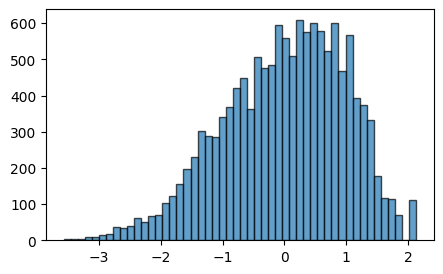

In [7]:
# Plot normalised data
plt.figure(figsize=(5, 3))
plt.hist(cleaned_songs['Artist Popularity Scaled'], bins=50, alpha=0.7, edgecolor='black')
plt.show()

<u>**Convert decade released column to integers**</u>

In [8]:
# Convert decade release column to integers
cleaned_songs['Numerical Decade Released'] = cleaned_songs['Decade Released'].map({
    '1940s': 1940,
    '1950s': 1950,
    '1960s': 1960,
    '1970s': 1970,
    '1980s': 1980,
    '1990s': 1990,
    '2000s': 2000,
    '2010s': 2010,
    '2020s': 2020,
})

<u>**Convert Multiple Genres to Array**</u>\
There are multiple songs with multiple genres. We want to convert this string of multiple genres to an array of genres instead.

In [9]:
#Splitting the string by commas
cleaned_songs["separated genres"] = data["Artist Genres"].str.split(',') 

#Stripping whitespace from the splitted strings
cleaned_songs["separated genres"] = cleaned_songs["separated genres"].apply(lambda genres: [genre.strip() if isinstance(genre, str) else genre for genre in genres]) 

cleaned_songs["separated genres"]

2                           [bedroom pop, pop, pov: indie]
4                                [gen z singer-songwriter]
6                                                    [pop]
7                                [gen z singer-songwriter]
9                                                  [k-pop]
                               ...                        
18477                                [big beat, breakbeat]
18478                                      [german techno]
18479                 [australian dance, melbourne bounce]
18480    [disco house, vocal house, dance pop, europop,...
18481    [australian dance, australian pop, dance pop, ...
Name: separated genres, Length: 13377, dtype: object

---

# **Regression Models to predict Track Popularity**


## <u>**Linear Regression**</u>

Let us naively try to predict Track Popularity using Linear Regression. Before we proceed, we will need to convert the genre list of each song into binary labels. Since each song can have multiple genres, we will need to use MultiLabelBinarizer to obtain a binary matrix.

In [10]:
#Applying MultiLabelBinarizer on our arrays of genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(cleaned_songs['separated genres'])

Now that genres is now represented by a binary matrix, we can set our predictor and respone variables.

In [11]:
#Setting the predictor variable as a combination of genres, artist popularity and album release date
X = np.hstack((genres_encoded, cleaned_songs['Artist Popularity Scaled'].values.reshape(-1,1), cleaned_songs['Numerical Decade Released'].values.reshape(-1,1)))

#Setting the response variable as the track popularity
y = cleaned_songs['Track Popularity']

#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

Now let us carry out Linear Regression.

In [12]:
#Initialising the model
linreg = LinearRegression()

#Fitting the model on the train data
linreg.fit(X_train, y_train)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

#Predicting the train and test response variable
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

Intercept of Regression 	: b =  472.46981404333644
Coefficients of Regression 	: a =  [ 3.08119592e+13  2.72620774e+12 -7.14883588e-01 ...  7.95464325e+00
  9.96875000e+00 -2.08984375e-01]



Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.44673554410787797
Mean Squared Error (MSE): 	: 225.7577458494516
Root Mean Squared Error (RMSE): 	: 15.02523696483525
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -8.645303007631154e+20
Mean Squared Error (MSE) : 	: 3.5759814420893076e+23
Root Mean Squared Error (RMSE): 	: 597995103833.5771



Text(0.5, 1.0, 'Test Dataset')

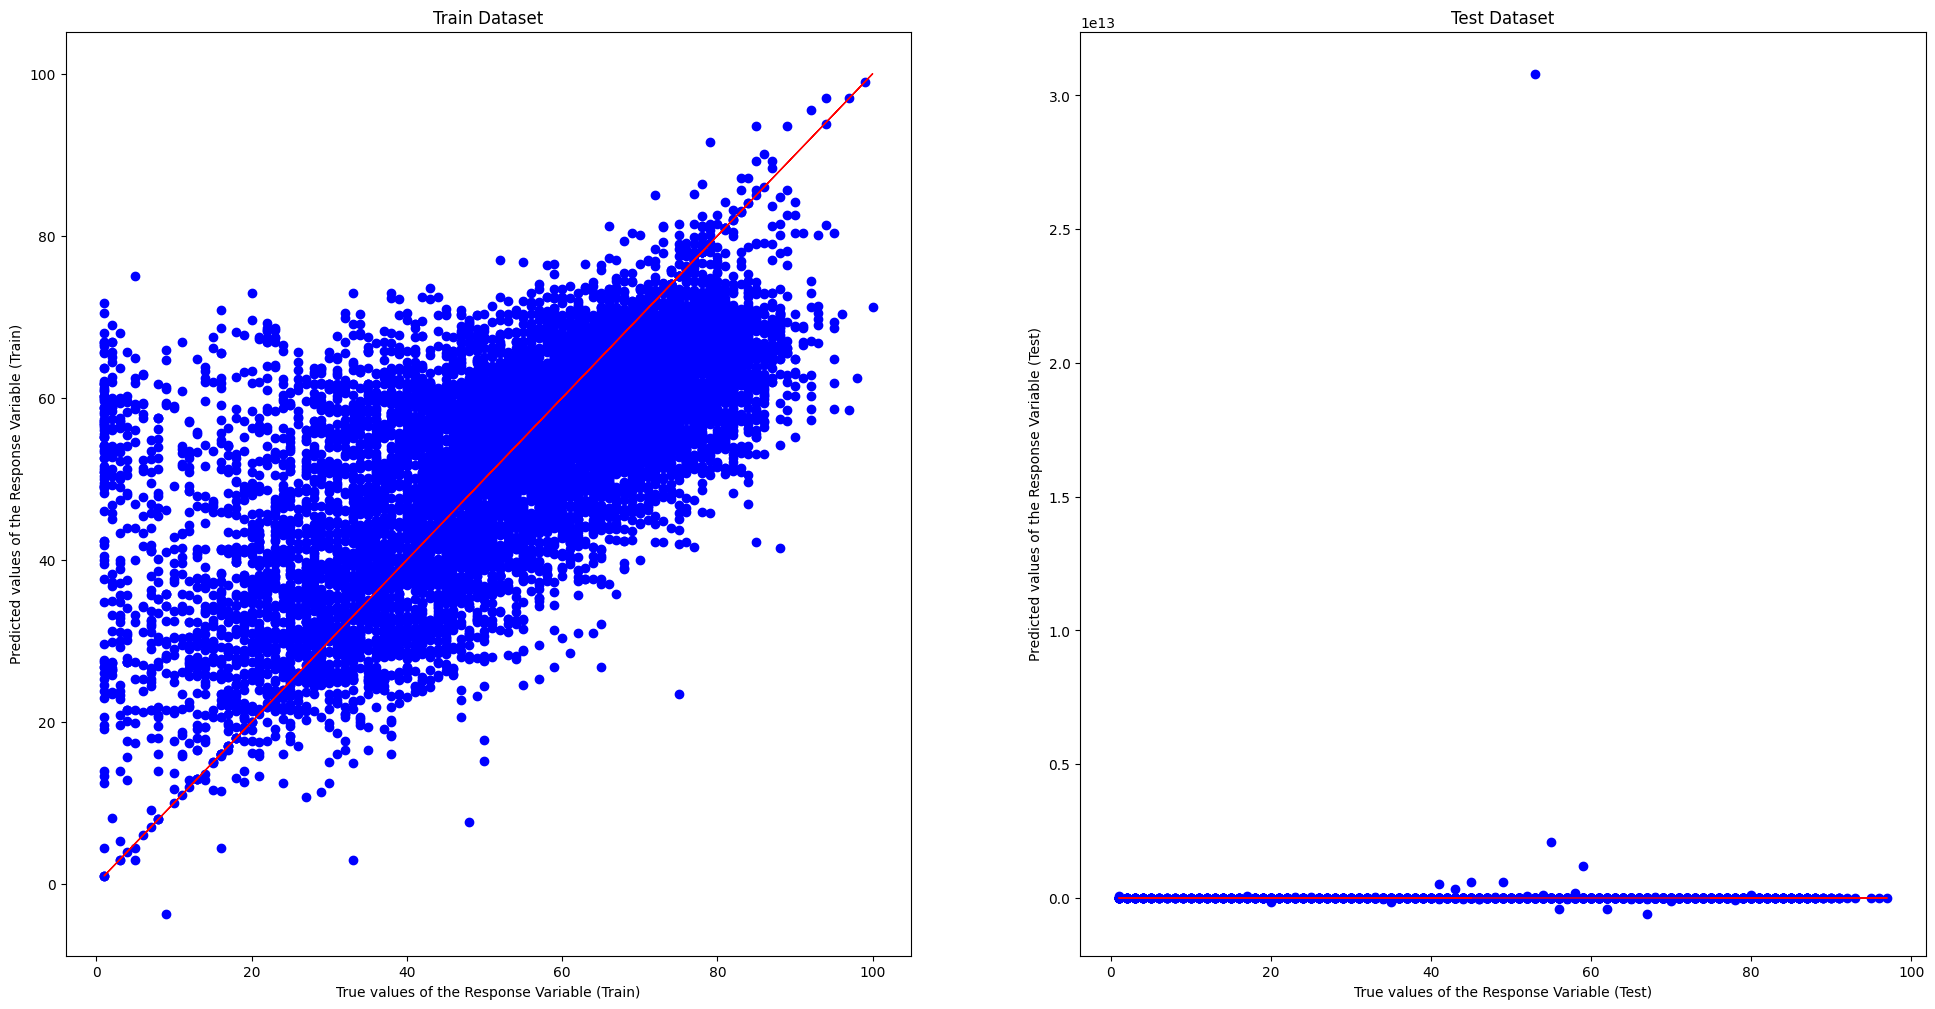

In [13]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))


# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

As expected, linear regression has proven to fail miserably. Looking at our test data, our model clearly fails as it predicts track popularity to values as far off as 10^11, when our range for track popularity is only 1 to 100. Perhaps we should look at other models that are more suited to analyse the complex relationships here.

## <u>**Lasso Regression**</u>

Let us try with Lasso Regression. LASSO stands for Least Absolute Shrinkage and Selection Operator. Essentially, it does feature selection and regularisation in order to enhance prediction accuracy.

In [14]:
# Using LassoCV to select features based on the strength of the regularization
selector = SelectFromModel(LassoCV(cv=5))
X_selected = selector.fit_transform(X, y)

#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=9)

#Printing the shape of X
print("X shape: " + str(X.shape))

#Printing the shape of X_selected
print("X_selected shape: " + str(X_selected.shape))

X shape: (13377, 1448)
X_selected shape: (13377, 157)


As seen, Lasso has reduced the number of columns rather drastically. It has done so by removing features (columns) that it has deemed to be insignificant or irrelevant.

In [15]:
#Initialising the model
lassoreg = LinearRegression()

#Fitting the model on the train data
lassoreg.fit(X_train, y_train)

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', lassoreg.intercept_)
print('Coefficients of Regression \t: a = ', lassoreg.coef_)
print()

#Predicting the train and test response variable
y_train_pred = lassoreg.predict(X_train)
y_test_pred = lassoreg.predict(X_test)

Intercept of Regression 	: b =  384.8468296372931
Coefficients of Regression 	: a =  [  6.12317354  -1.82460997   3.94227266   0.12963706   6.06786005
  -5.6039625  -12.83601725  -7.13012691   3.94863686   3.87870924
   2.83644681  -5.82730236  -7.06337949  -3.30843886  -5.53581758
  -4.7697707   -5.20074351  -6.9399433   -8.01156704  -6.51510566
  -5.24640898   2.31822304  -2.6305022   -8.75145601   5.0995515
  -0.42323252  -3.20468607  -6.35070476   1.29602944   1.5415374
  -4.28934669   9.93129217  22.36291746  -0.38627283  -3.8988447
 -11.60949576   7.09683586  -5.33747343  -1.23432945  -2.39090069
 -12.35467513  18.4872088   -9.48508195   6.67231766   4.01862849
  -1.74507913  -5.45060264  -2.71062734   9.24101951  -3.84259452
  -4.75947196  -5.5167294   -9.80404331  -2.38386138  -2.15462876
  -0.76737844  -6.78952692  -7.60063295  -8.55673593   2.5665434
  -4.09690293  -4.6554653  -19.24692908  -3.73738772  10.44964603
  -9.01639827   2.59843423   3.93385735  -3.56105757 -10.7868

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.38826842255613536
Mean Squared Error (MSE): 	: 249.61506295568728
Root Mean Squared Error (RMSE): 	: 15.799210833319723
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.385335325002931
Mean Squared Error (MSE) : 	: 254.24550984010483
Root Mean Squared Error (RMSE): 	: 15.9450779189098



Text(0.5, 1.0, 'Test Dataset')

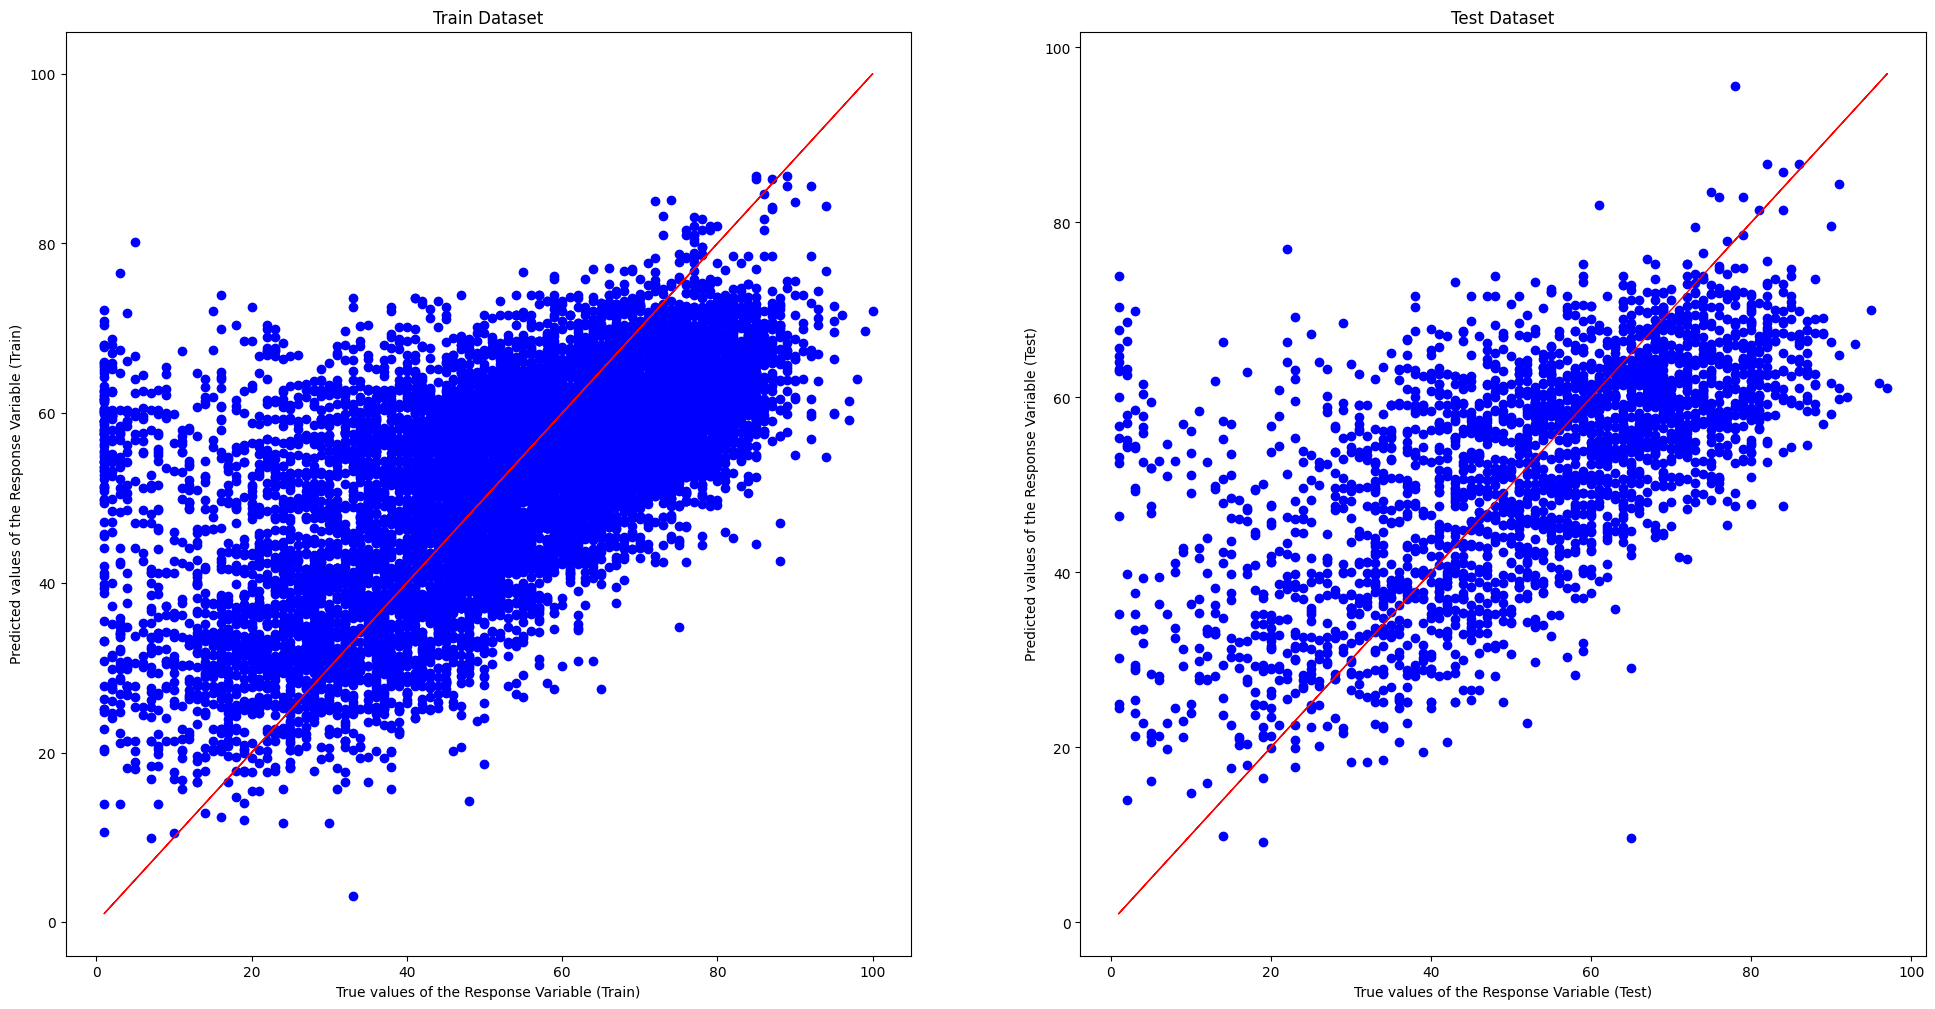

In [16]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", lassoreg.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", lassoreg.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

Lasso Regression has performed way better than Linear Regression, due to its feature selection and regularisation.

## <u>**Random Forest Regression**</u>

Random Forest works by constructing mutliple decision trees, but when splitting a node, it randomly selects a subset of the features as candidates for the split, and this randomness help to make the model more robust to noise in the data, as well as capture the complex interactions between predictor variables.

In [17]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, cleaned_songs['Track Popularity'], test_size=0.2, random_state=9)

#Initialising the Random Forest Regressor model
RFR = RandomForestRegressor(n_estimators=100, random_state=9)

#Fitting the model on the train data
RFR.fit(X_train, y_train)

#Predicting the train and test response variable
y_train_pred = RFR.predict(X_train)
y_test_pred = RFR.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.7024777762350611
Mean Squared Error (MSE): 	: 121.4029671741382
Root Mean Squared Error (RMSE): 	: 11.018301465023463
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.38463107017185383
Mean Squared Error (MSE) : 	: 254.5368127827791
Root Mean Squared Error (RMSE): 	: 15.954209876480222



Text(0.5, 1.0, 'Test Dataset')

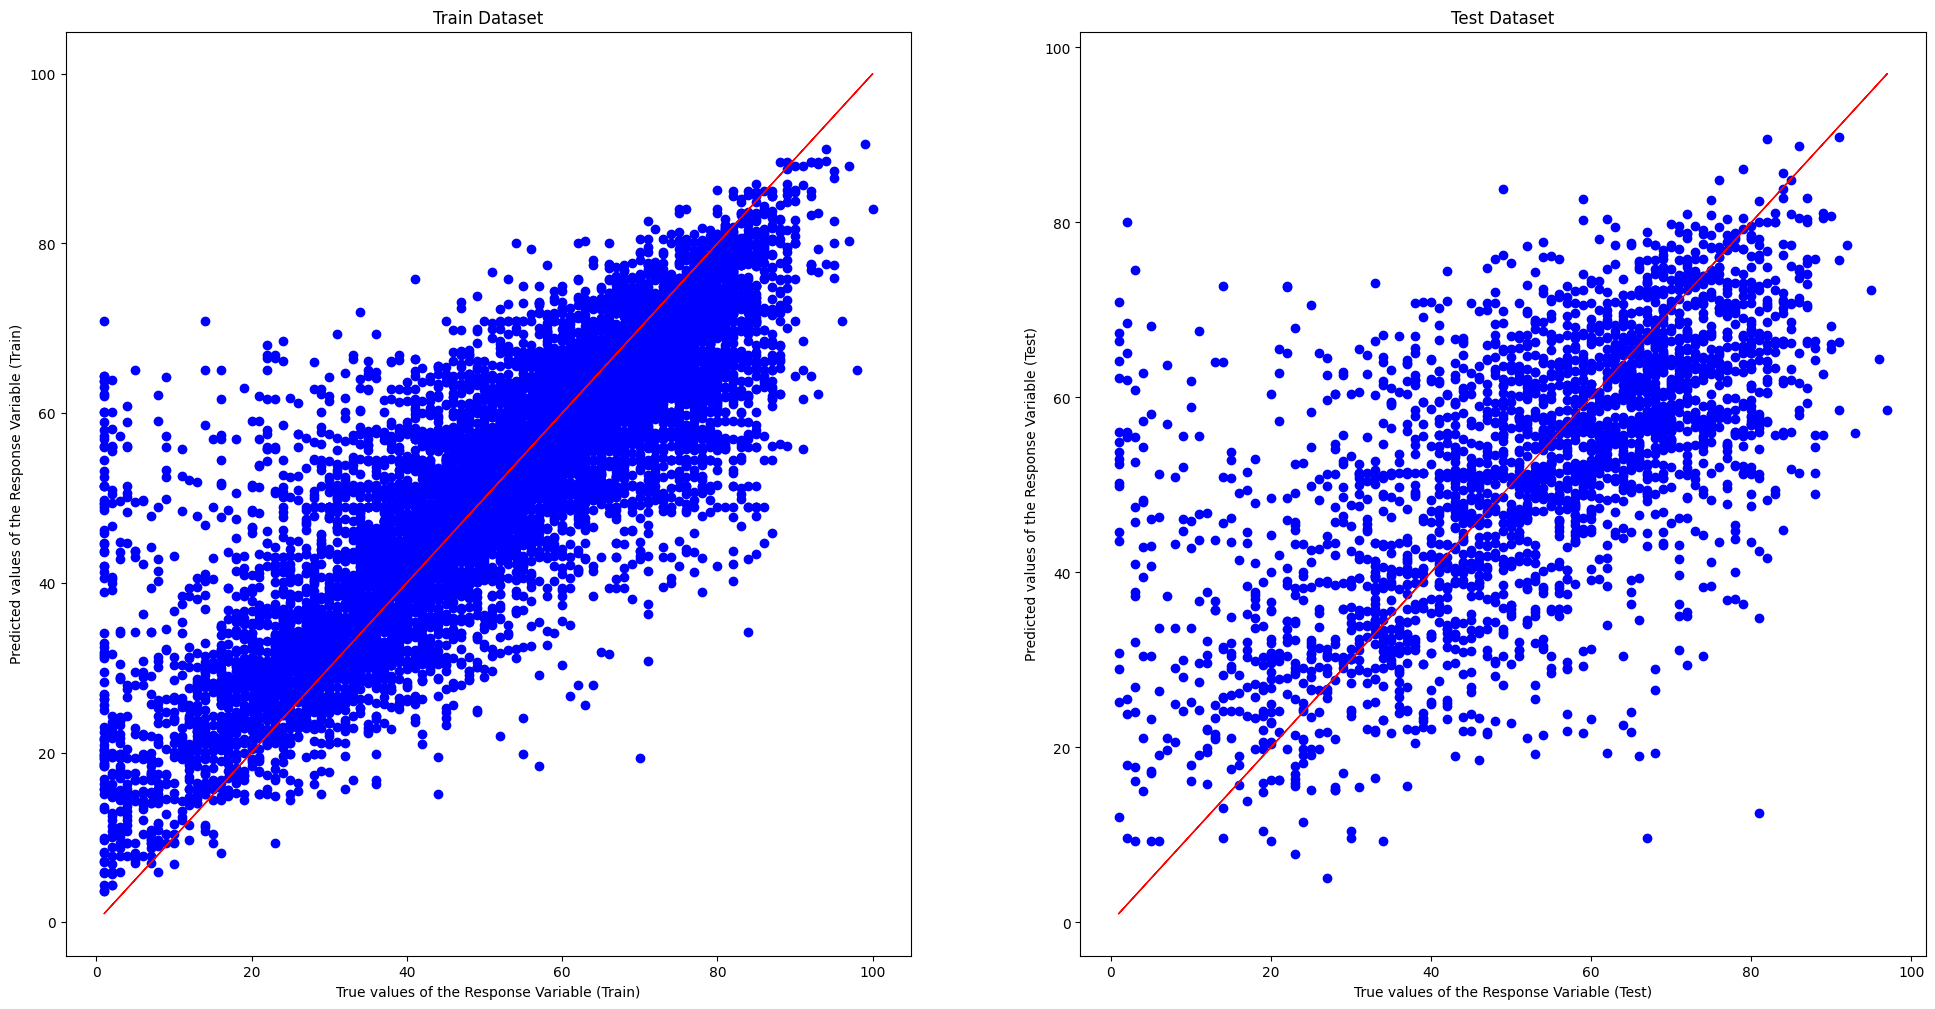

In [18]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", RFR.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", RFR.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

## <u>**Neural Network**</u>

Neural Network is a Machine Learning technique inspired by neural networks in animals, designed to recognise patterns. These neural networks receive input in the input layer and passes it into the hidden layer, where it performs computations using weighted inputs from many successive previous layers and passes it down again, before finally being output in the output layer.

In [19]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, cleaned_songs['Track Popularity'], test_size=0.2, random_state=9)

# Determine the number of input features
input_dim = X_train.shape[1]

NN = Sequential()
NN.add(Dense(128, input_dim=input_dim, activation='relu'))
NN.add(Dense(64, activation='relu'))
NN.add(Dense(1, activation='linear'))  # Linear activation for a single-value regression output
NN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

history = NN.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

#Predicting the train and test response variable
y_train_pred = NN.predict(X_train)
y_test_pred = NN.predict(X_test)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 579.6790 - mae: 19.0037 - mse: 579.6790 - val_loss: 391.3621 - val_mae: 15.8718 - val_mse: 391.3621
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 372.2675 - mae: 15.6187 - mse: 372.2675 - val_loss: 344.3835 - val_mae: 14.9392 - val_mse: 344.3835
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 340.4385 - mae: 14.7458 - mse: 340.4385 - val_loss: 345.3950 - val_mae: 13.8856 - val_mse: 345.3950
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 321.4670 - mae: 14.0843 - mse: 321.4670 - val_loss: 294.6279 - val_mae: 13.1775 - val_mse: 294.6279
Epoch 5/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 284.7151 - mae: 13.1931 - mse: 284.7151 - val_loss: 287.3048 - val_mae: 13.0129 - val_mse: 287.3048
Epoch 6/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 296.1811 - mae: 13.3469 - mse: 296.1811 - val_loss: 283.8706 - val_mae: 13.0186 - val_mse: 283.8706
Epoch 7/100
301/301 ━━━━━━━━━━━━━━━━━━

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3771747668999339
Mean Squared Error (MSE): 	: 254.14179274557713
Root Mean Squared Error (RMSE): 	: 15.941825263926873
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.33636057045360335
Mean Squared Error (MSE) : 	: 274.50307782178066
Root Mean Squared Error (RMSE): 	: 16.56813440981756



Text(0.5, 1.0, 'Test Dataset')

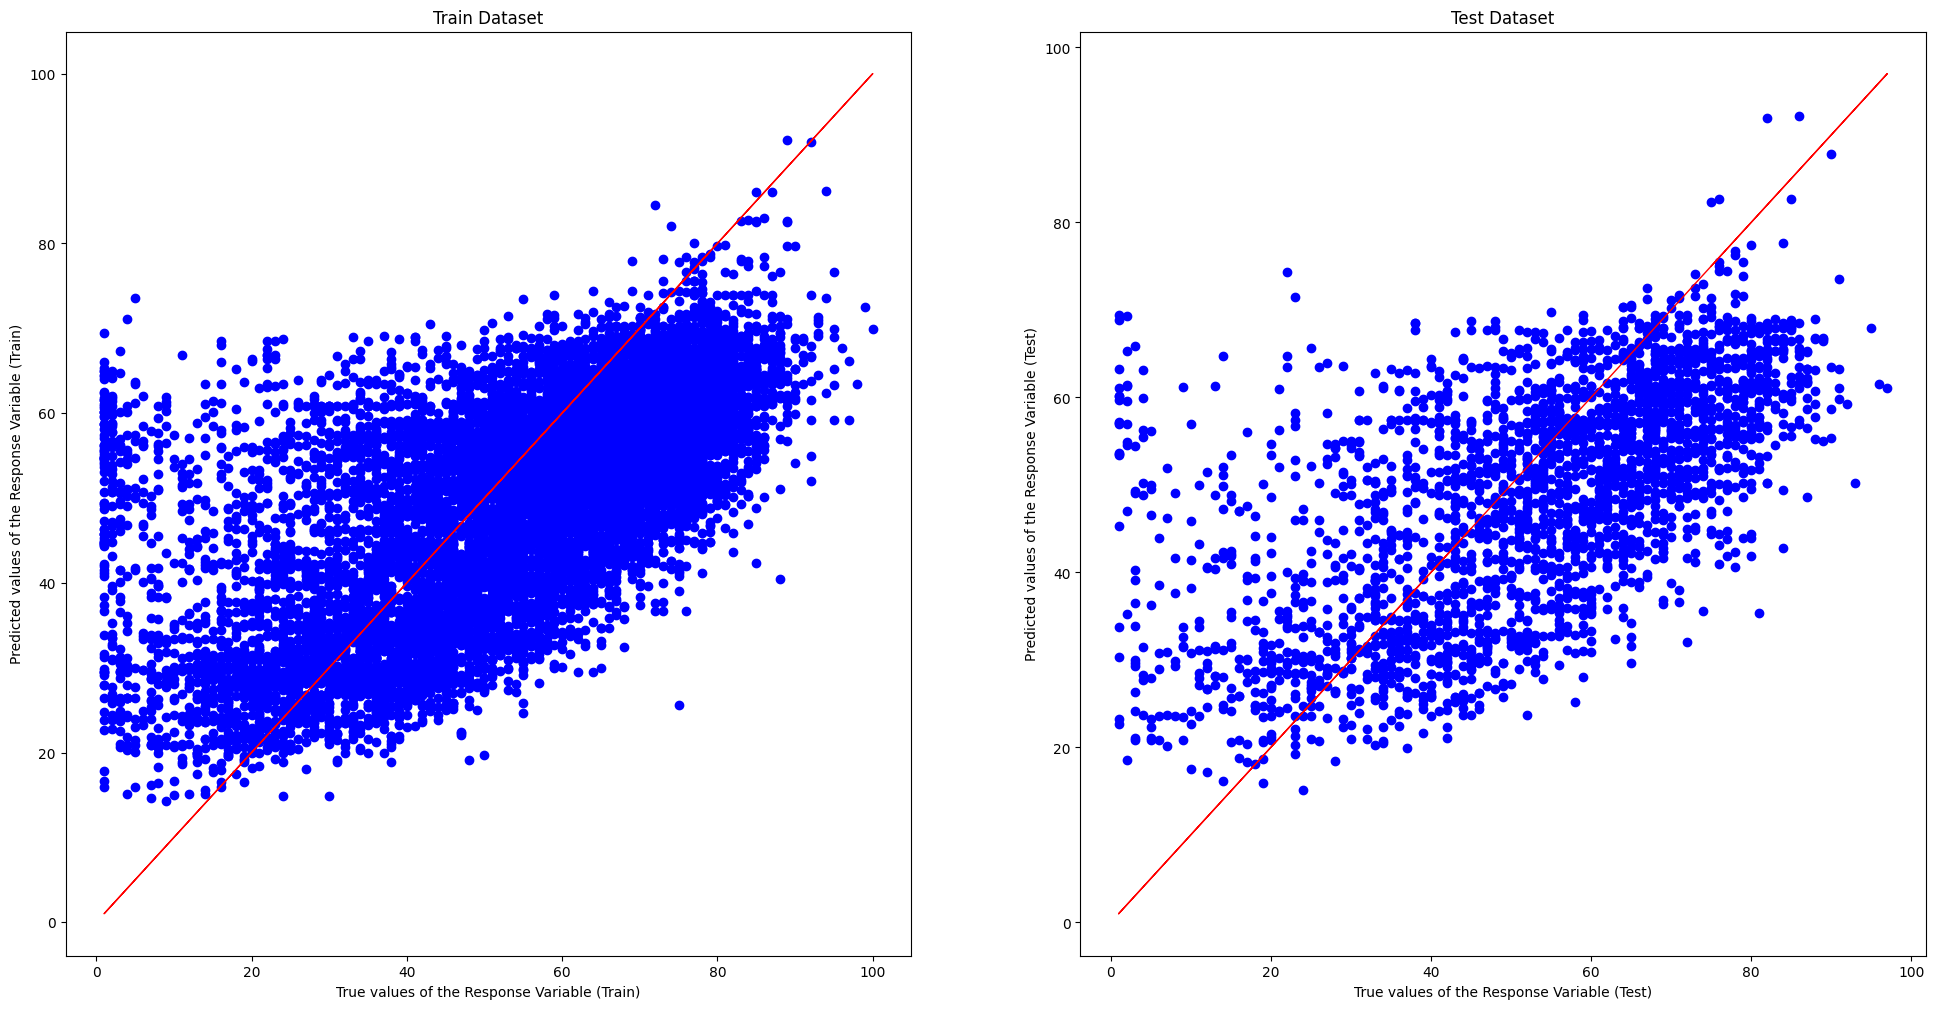

In [20]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_train, y_train_pred))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_score(y_test, y_test_pred))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

## <u>**Gradient Boosting with Decision Trees**</u>

Gradient boosting with decision trees is essentially a series of decision trees which aim to correct the mistakes of the previous decision tree model.

In [21]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, cleaned_songs['Track Popularity'], test_size=0.2, random_state=9)

GBR = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=9)

# Fitting the model on the train data
GBR.fit(X_train, y_train)

#Predicting the train and test response variable
y_train_pred = GBR.predict(X_train)
y_test_pred = GBR.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5291809966207338
Mean Squared Error (MSE): 	: 192.11614947249308
Root Mean Squared Error (RMSE): 	: 13.860597009959314
Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.4244251395507278
Mean Squared Error (MSE) : 	: 238.07667790046693
Root Mean Squared Error (RMSE): 	: 15.429733565440037



Text(0.5, 1.0, 'Test Dataset')

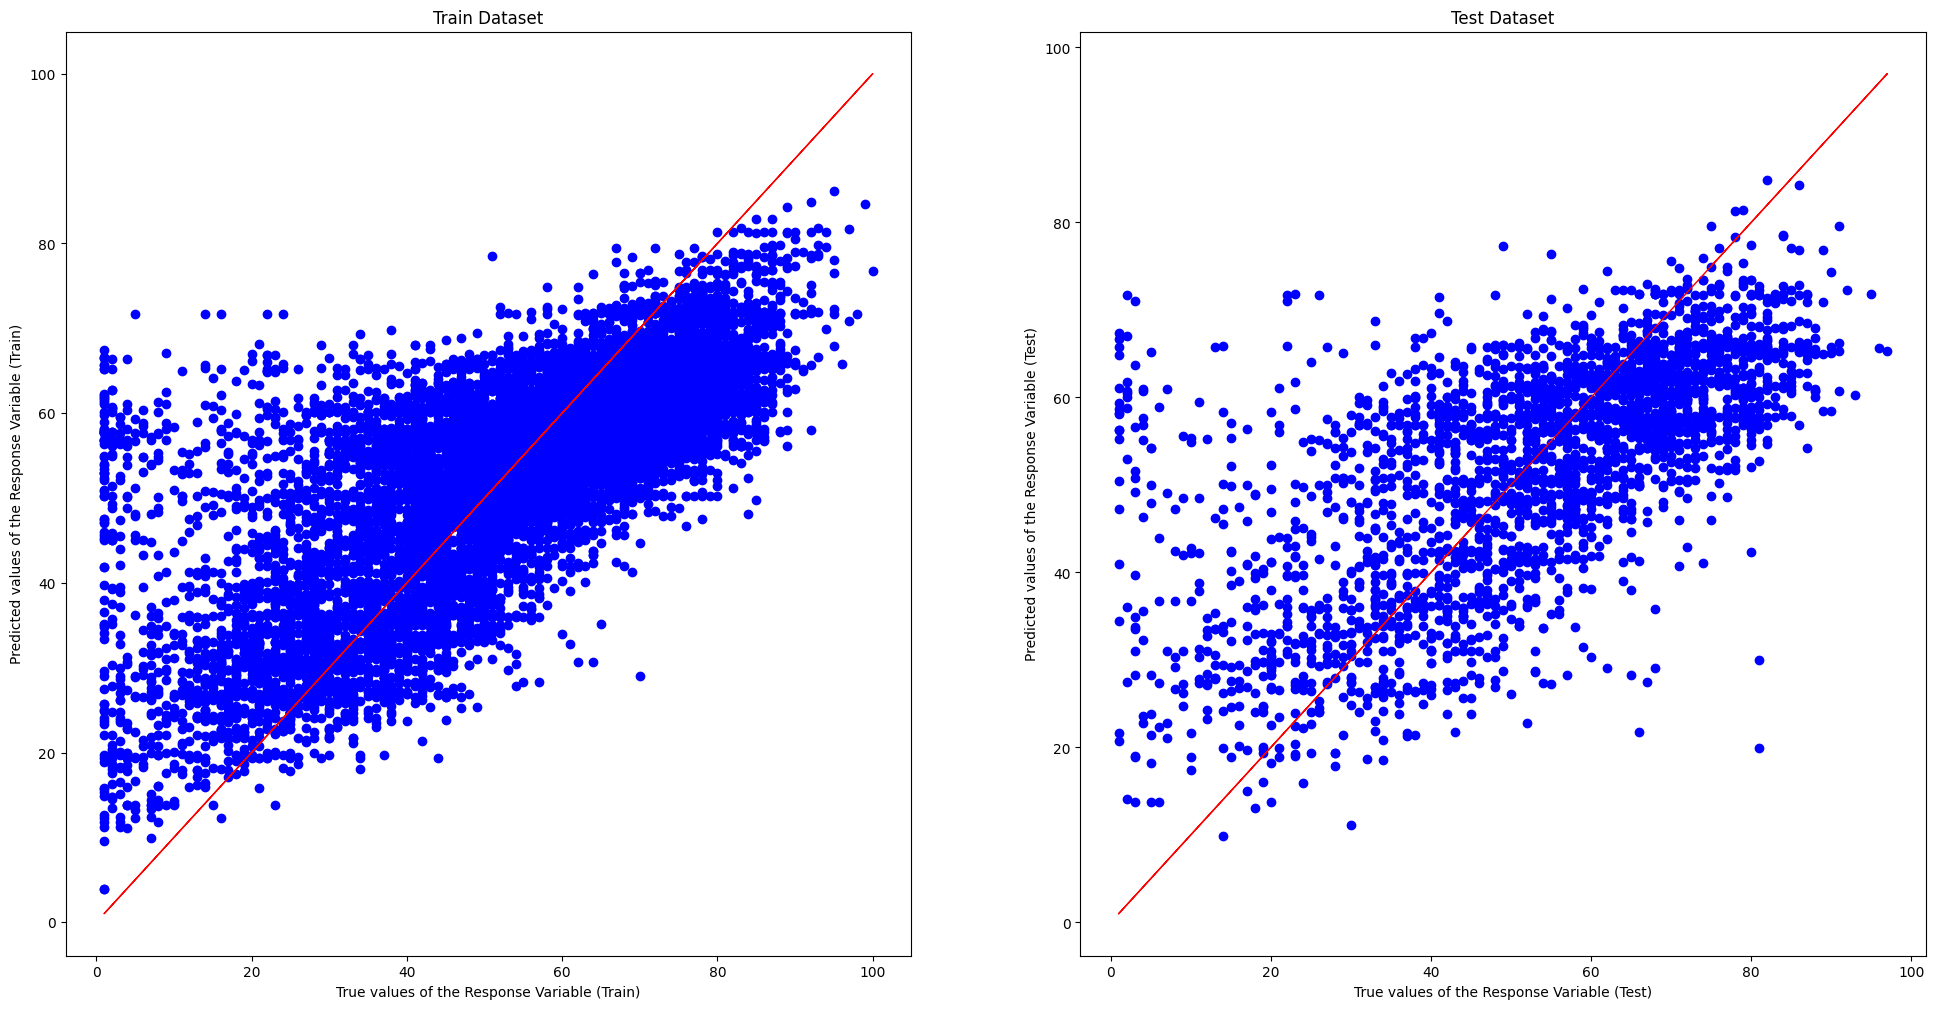

In [22]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", GBR.score(X_train, y_train))
print("Mean Squared Error (MSE): \t:", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", GBR.score(X_test, y_test))
print("Mean Squared Error (MSE) : \t:", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): \t:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print()

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[0].set_title("Train Dataset")

axes[1].scatter(y_test, y_test_pred, color = "blue")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
axes[1].set_title("Test Dataset")

### <u>**Evaluation**</u>

Comparing the regression models, <u>***Gradient Boosting with Decision Trees***</u> is likely the best model, since it has the <u>greatest explained variance</u>, and also has the <u>lowest RMSE</u>

However, it still has its limitations, as the explained variance is not exactly very high, nor is the RMSE low either. Hence, the model could be useful in predicting an approximation of the Track Popularity, but the results should be taken with a pinch of salt.

Despite its somewhat low level of accuracy, when considering these results in the field of social science, the accuracy can actually be considered to be rather decent.

---

# **Classification Models to predict Track Popularity**
After evaluating the above regression models, it was not the most accurate predictor of popularity, or at least could not reliably predict the exact popularity level. Perhaps our models will be more reliable if we convert it into a classification problem and determine simply if it will be popular or not.

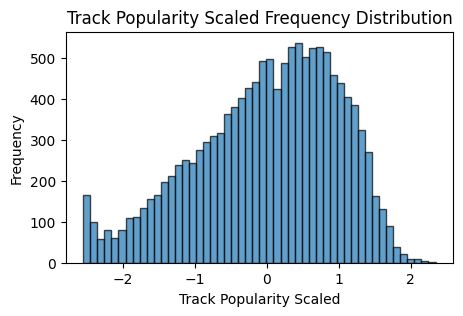

In [23]:
# Normalising and scaling track popularity
track_scaler = StandardScaler()
cleaned_songs['Track Popularity Scaled'] = track_scaler.fit_transform(cleaned_songs[['Track Popularity']])

# Plot a histogram of artist popularity scaled
plt.figure(figsize=(5, 3))
plt.hist(cleaned_songs['Track Popularity Scaled'], bins=50, alpha=0.7, edgecolor='black')

plt.title('Track Popularity Scaled Frequency Distribution')
plt.xlabel('Track Popularity Scaled')
plt.ylabel('Frequency')
plt.show()

In order to determine if a track is popular or not, we must first decide on a threshold for popularity. There are multiple ways of defining this threshold, but for this case, let us plot track popularity as a normally distributed graph, with mean = 0 and standard deviation = 1. Any tracks with a scaled track popularity of greater than 0 will be deemed popular, while all other tracks will be deemed as not popular. In other words, a track is popular if its popularity is greater than the median track popularity.

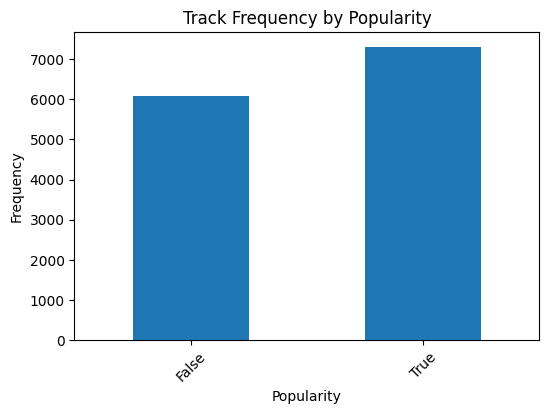

In [24]:
#function to return whether a track is popular or not based on its scaled track popularity
def popular_or_not(scaled_popularity):
    if scaled_popularity > 0:
        return True
    else:
        return False
    
#Creating a new column with boolean values indicating whether the track is popular or not
cleaned_songs['Popular'] = cleaned_songs["Track Popularity Scaled"].apply(popular_or_not)

popular_unpopular = cleaned_songs['Popular'].value_counts().sort_index()

# Plotting the histogram/bar plot of decade frequencies
plt.figure(figsize=(6, 4))
popular_unpopular.plot(kind='bar')
plt.title('Track Frequency by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## <u>**Logistic Regression**</u>

Logistic Regression is a model that predicts binary varables based on linear combination of one or more independent variables.

True positive rate	:  0.8143835616438356
True negative rate	:  0.6603618421052632
False positive rate	:  0.33963815789473684
False negative rate	:  0.18561643835616437
Overall Accuracy	:  0.7443946188340808


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

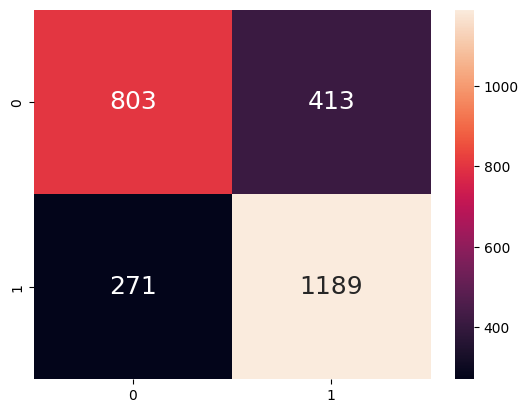

In [25]:
#Setting the predictor variable as a combination of genres, artist popularity and album release date
X = np.hstack((genres_encoded, cleaned_songs['Artist Popularity Scaled'].values.reshape(-1,1), cleaned_songs['Numerical Decade Released'].values.reshape(-1,1)))

#Setting the response variable as the track popularity
y = cleaned_songs['Popular']

#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

#Initialising the model, with max iterations set at 1000 to prevent the algorithm from stopping the optimisation process before finding the best coefficients
LogReg = LogisticRegression(max_iter=1000)

#Fitting the model with the train data
LogReg.fit(X_train, y_train)

#Predicting the popularity of test data
y_pred = LogReg.predict(X_test)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

## <u>**Logistic Lasso Regression**</u>

Logistic Lasso Regression combines Logistic Regression and Lasso Regression, using feature selection and regularisation in the Logistic Regression model.

In [26]:
# Using LassoCV to select features based on the strength of the regularization
selector = SelectFromModel(LassoCV(cv=5, random_state=9))
X_selected = selector.fit_transform(X, y)

#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=9)

#Printing the shape of X
print("X shape: " + str(X.shape))

#Printing the shape of X_selected
print("X_selected shape: " + str(X_selected.shape))

X shape: (13377, 1448)
X_selected shape: (13377, 128)


True positive rate	:  0.8397260273972603
True negative rate	:  0.6554276315789473
False positive rate	:  0.34457236842105265
False negative rate	:  0.16027397260273973
Overall Accuracy	:  0.7559790732436472


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

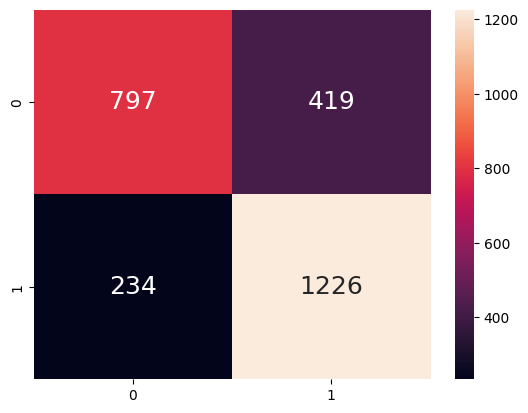

In [27]:
LogReg = LogisticRegression(max_iter=1000)
LogReg.fit(X_train, y_train)

#Predicting the popularity of test data
y_pred = LogReg.predict(X_test)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

## <u>**Random Forest Classifier**</u>

Random Forest Classifier is similar to the Random Forest Regression, but instead it outputs a class.

True positive rate	:  0.7986301369863014
True negative rate	:  0.7146381578947368
False positive rate	:  0.28536184210526316
False negative rate	:  0.20136986301369864
Overall Accuracy	:  0.7604633781763827


<Axes: >

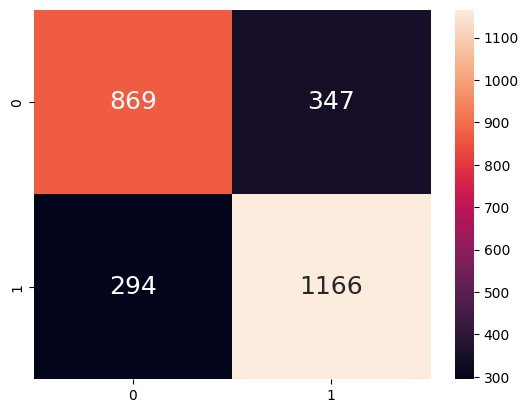

In [28]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

#Initialising the Random Forest Classifier model
RFC = RandomForestClassifier(n_estimators=100, random_state=9)

#Fitting the model on the train data
RFC.fit(X_train, y_train)

#Predicting the popularity of test data
y_pred = RFC.predict(X_test)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

## <u>**Support Vector Machines**</u>

Support Vector Machines (SVMs) is based on the idea of finding a hyperplane that best divides a dataset into classes.

True positive rate	:  0.8533886583679114
True negative rate	:  0.5666666666666667
False positive rate	:  0.43333333333333335
False negative rate	:  0.14661134163208853
Overall Accuracy	:  0.7215994020926756


<Axes: >

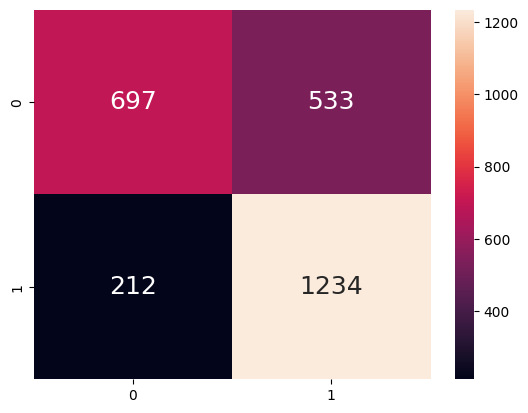

In [29]:
#Splitting the train and test in a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

#SVMs need the predictor variables to be scaled
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Setting the kernal as 'rbf' is suitable for non-linear problems
SVM = SVC(kernel='rbf')
SVM.fit(X_train_scaled, y_train)

#Predicting the popularity of test data
y_pred = SVM.predict(X_test_scaled)

#Initialising the confusion matrix
CM = confusion_matrix(y_test, y_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("True positive rate\t: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("True negative rate\t: ", TNR)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive rate\t: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate\t: ", FNR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy\t: ", ACC)

#Displaying the confusion matrix
sb.heatmap(CM, 
        annot = True, fmt=".0f", annot_kws={"size": 18})

### <u>**Evaluation**</u>
Based on the results, <u>***Random Forest Classifier***</u> seems to be the most suitable Classification model. It has the <u>highest accurazy</u>, and also the <u>lowest False Positive rate</u>. FPR is important to minimise in our case since we do not want to waste resources investing on an artist who underperforms.

---

# **Predicting Track Popularity**

Now that we have decided the best Regression and Classification models, we can use them to predict the popularity of songs based on the independent variables that we can set values to.

In [30]:
#Set the values of the independent variables here
new_data_genres = ["finnish pop", "pop"] 
new_data_artist_popularity = [[40]]  
new_data_decade_released = [2020]


#Reshaping the new decade into a numpy array of dimension 2
new_data_decade_released = np.array(new_data_decade_released).reshape(1, -1)

#Scaling the artist popularity using the same scaler as before
new_data_artist_popularity_scaled = artist_scaler.transform(new_data_artist_popularity)

#Encoding the new genres using the same MultiLabelBinarizer as before
new_genres_encoded = mlb.transform([new_data_genres])

#Stack the features in the same order as the training data
new_X = np.hstack((new_genres_encoded, new_data_artist_popularity_scaled, new_data_decade_released))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
# Predict using the regression model
predicted_y = GBR.predict(new_X)

#Predict using the classification model
predicted_y_boolean = RFC.predict(new_X)

# Output the prediction 
print(f"The predicted track popularity by Gradient Boosting is: {predicted_y[0]}")

if (predicted_y_boolean[0]):
    print("Random Forest Classifier predicts this song to be popular")
else:
    print("Random Forest Classifier predicts this song to be NOT popular")



The predicted track popularity by Gradient Boosting is: 32.988889849016196
Random Forest Classifier predicts this song to be NOT popular
